# Ideas for future
* Avg time spent on blog
* Avg page depth of blog

### Pillars meeting notes 02/19/2019
* algolia report send every week  
* add in changes over time  
* maybe some benchmarks  
* look around, explore, develop this, find some insights  
* look at searches with zero hits  

### Email Resources
* Email with subject line "Fwd: Discrepancy between Google Analytics and Algolia"
* 2018-07-21 is when zephyr updated the tracking capabilities of GA, see email mentioned above
* Email with subject line "How to view defined Event Actions in Google Analytics"
* Email with subject line "Google Analytics: Shop vs www.Adafruit.com"

### Google Analytics resources
* [Difference between Entrances and Sessions](https://support.google.com/analytics/answer/2956047?hl=en)
* [Behavior Flow help page](https://support.google.com/analytics/answer/2785577?hl=en)
* [Difference between Starting Page and Landing Page in Behavior Flow](https://webmasters.stackexchange.com/questions/99267/whats-the-difference-between-landing-page-and-starting-page-in-behaviour-fl)
* [Info on PagePathLevels and Session count discrepancy](https://www.quora.com/In-Google-analytics-custom-Reporting-what-is-Page-path-level-definition)
* [How Site Search metrics are calculated](https://support.google.com/analytics/answer/1032321?hl=en)

### Dimensions and Metrics Explorer for API
* https://developers.google.com/analytics/devguides/reporting/core/dimsmets

### Google2Pandas Docs
* https://github.com/panalysis/Google2Pandas

### Other notes
* Do this for Shop, Learn Guides, and Internal (for Tom)

### Libraries

In [1]:
import sys
sys.path.insert(0,'/Users/jarad/Fake Folder/Python Libraries/')

from jb_libraries import *
from jb_google_analytics import *
%matplotlib inline


== jb_google_analytics start ==

Your ga function is: get_ga(account_id, date_start, date_end, dimensions, metrics, filters)

Beware of sampling!

== jb_google_analytics end ==



### Settings

In [2]:
report_dict = {}

In [3]:
# should be the most recent sunday, if you run this every monday
# valid if you run this every monday
date_end = str((dt.datetime.now() - pd.DateOffset(days = 1)).date()) 

one_year_ago = str((pd.to_datetime(date_end) - pd.DateOffset(weeks = 52, days = -1)).date())
three_months_ago = str((pd.to_datetime(date_end) - pd.DateOffset(weeks = 12, days = 6)).date())
four_weeks_ago = str((pd.to_datetime(date_end) - pd.DateOffset(weeks = 4, days = -1)).date())
one_week_ago = str((pd.to_datetime(date_end) - pd.DateOffset(weeks = 1, days = -1)).date())

write_workbook = 'yes'

# 'year and month','year and quarter','week ending'
report_type = 'week ending'

csv_path = '/Users/jarad/Fake Folder/New Products/Recurring/Algolia Searches Report/CSVs/'

In [4]:
t = ' - Algolia Searches Report'

d = pd.to_datetime(date_end)

year = str(d.year)
quarter = str(d.quarter)
month_num = date_end[5:7]
month_name = calendar.month_abbr[int(month_num)]
month_num = str(month_num)

if report_type == 'year and quarter':
    workbook_title = year + ' - ' + 'Q' + quarter + t
elif report_type == 'year and month':
    workbook_title = year + ' - ' + month_num + ' - ' + month_name + t
elif report_type == 'week ending':
    workbook_title = 'w.e ' + date_end + t
else:
    workbook_title = 'no title'
    
print(workbook_title)    

w.e 2019-03-17 - Algolia Searches Report


### Set accounts

In [5]:
adafruit_id = 15556579

### Define page_clean function

In [6]:
learn_guides = pd.read_sql(
'''
SELECT
LOWER(url) AS url
FROM learn_guides
''', db)

col_fix(learn_guides)

learn_guides['url clean'] = learn_guides['url'].str.replace('https://learn.adafruit.com','')

# list of tuples vs dictionary, of regex:value pairs
# https://stackoverflow.com/questions/33343680/can-a-regular-expression-be-used-as-a-key-in-a-dictionary

def page_clean(x):
    
    d = [
         ('category|categories','categories'),
         ('^\/search|^\/\?s=|^\/\?q=','search'),
         ('^\/$','main page'),
         ('checkout','checkout'),
         ('^\/product','product'),
         ('wishlist','wishlists'),
         ('account_history_info','account history info'),
         ('galleries','galleries'),
         ('back_in_stock_notification_subscribe','back in stock subscribe'),
         ('manage_subscription','manage subscription'),
         ('^\/[0-9]{4}\/[0-9]{2}\/[0-9]{2}','blog post'),
         ('^\/assets','assets page'),
         ('^\/author', 'author page'),
         ('^\/tag','tag page')
        ]
        
    # find learn guides    
    if any(l in x for l in learn_guides['url clean'].tolist()):
        return 'learn guide'
        
    # if the page title is "/some_word" or "/some_word/" and not just "/" or "/some_number"
        # then take that single word
    elif re.search(r'^/[a-z0-9_]*/*$', x) and re.search('^\/$', x) == None and re.search('^\/[0-9]*/*$', x) == None:
        return x.replace('/','')
    
    # go through regex dict
    else:
        for k,v in d:
            if re.search(k, x):
                return v

### Define get_trend

In [7]:
def get_trend(array):
    
    x = range(len(array))
    y = array
    
    z = np.polyfit(x,y,1)
    slope = z[0]
    intercept = z[1]
    
    return slope

*****
# Check out all GA hostnames
*****

In [8]:
hostnames = get_ga(15556579, # www.adafruit.com account ID
                  one_week_ago,
                  date_end,
                  ['hostname'],
                  ['pageviews'],
                  None)

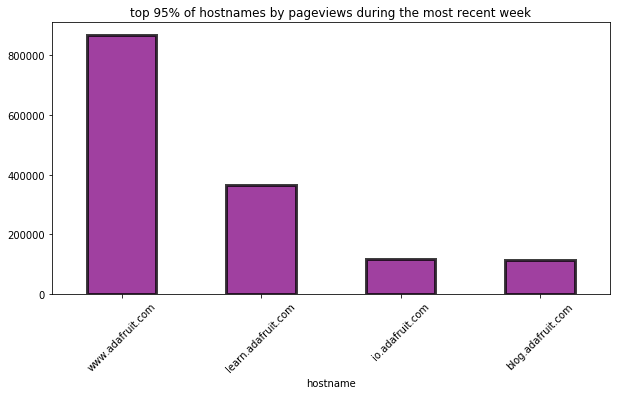

In [9]:
g1 = hostnames.groupby('hostname')[['pageviews']].sum()
g1.sort_values('pageviews', ascending = False, inplace = True)

g1['% of total'] = g1['pageviews']/g1['pageviews'].sum()
g1['% running sum'] = g1['% of total'].cumsum()

q = 0.95
g2 = g1[g1['% running sum'] <= q]

g2['pageviews'].plot(figsize = (10,5),
                     kind = 'bar', 
                     color = 'purple',
                     edgecolor = 'black',
                     alpha = 0.75,
                     lw = 3,
                     rot = 45,
                     title = 'top {:,.0f}% of hostnames by pageviews during the most recent week'.format(q*100))
plt.show()

### Define hostname filter

In [10]:
hostname_ls = ['www.adafruit.com','learn.adafruit.com']

hostname_filter = hostname_ls.copy()
hostname_filter = ['hostname==' + x for x in hostname_filter]

for n in np.arange(1,len(hostname_ls) + 1):
    if n%2 != 0:
        hostname_filter.insert(n,'or')
        
hostname_filter        

['hostname==www.adafruit.com', 'or', 'hostname==learn.adafruit.com']

*****
# Overall GA stats
*****

### Get data

In [11]:
s = dt.datetime.now()
   
overall_super_main = get_ga(adafruit_id,
                            three_months_ago,
                            date_end,

                            ['hostname',
                             'date'], 

                            ['sessions',
                             'searchSessions',
                             'users',
                             'searchUniques', # Total number of unique keywords from internal searches within a session. For example, if "shoes" was searched for 3 times in a session, it would be counted only once.
                             'searchExits', # The number of exits on the site that occurred following a search result from the site's internal search feature.
                             'pageviews'],

                            hostname_filter)

e = dt.datetime.now()
print(e-s)

0:06:02.419993


### Structure

In [12]:
overall_main = overall_super_main.copy()

overall_main.rename(columns = {'search sessions':'sessions with search',
                               'search uniques':'unique searches'}, inplace = True)

# get week ending, using my function
df = jb_week_ending(overall_main, 'date', 'Sunday')
overall_main = pd.merge(overall_main, df, on = 'date')

### Summarize

In [13]:
d1 = overall_main['date'].min().date()
d2 = overall_main['date'].max().date()
days = (pd.to_datetime(d2) - pd.to_datetime(d1)).days

for hostname in set(overall_main['hostname']):
    
    report_dict[hostname + ' overall period'] = '%s to %s (%i days).' % (d1,d2,days)
    
#=========================
# get data by report_type
#=========================
    
    a1 = overall_main[overall_main['hostname'] == hostname]
    a2 = a1.groupby(report_type)[['users',
                                  'sessions',
                                  'sessions with search',
                                  'unique searches',
                                  'search exits',
                                  'pageviews']].sum()

    a2['% of sessions with search'] = a2['sessions with search']/a2['sessions']
    a2['avg search per search session'] = a2['unique searches']/a2['sessions with search']
    a2['avg pageview per session'] = a2['pageviews']/a2['sessions']
    a2['search exits as % of unique searches'] = a2['search exits']/a2['unique searches']
    a2.fillna(0, inplace = True)
    
    old_cols = a2.columns.tolist()

    cols1 = sorted([x for x in old_cols if 'search' in x], reverse = True)
    cols2 = sorted([x for x in old_cols if 'pageview' in x], reverse = True)
    cols3 = [x for x in old_cols if x not in cols1 + cols2]

    new_cols = cols3 + cols1 + cols2
    a2 = a2[new_cols]
    
    report_dict[hostname + ' overall over time'] = a2
    
#=========================
# get confidence interval
#=========================    
    
    conf = jb_conf(a2).loc[:'upper'].T
    
    report_dict[hostname + ' overall conf'] = conf
    
#=========================
# get trend
#=========================    
    
    a3 = a2.T
    vals = a3.values
    ls = []
    for i in range(len(vals)):
        slope = get_trend(vals[i])
        results = 'up' if slope > 0 else 'down'
        ls.append(results)    
        
#=========================
# isolate most recent week
#=========================    

    a4 = pd.DataFrame(a3.iloc[:,-1])
    a4.columns = ['week ending ' + x for x in a4.columns]
    
#=========================
# add in avg and trend
#=========================    

    a4['average'] = conf['mean']
    a4['week to week trend'] = ls
    
#=========================
# add in confidence interval results
#=========================    

    ls = []
    for index, row in a4.iterrows():
        lower, mean, upper = conf.loc[index].values
        val = row.values[0]
        if np.logical_and(val >= lower, val <= upper):
            res = 'normal'
        else:
            if val < lower:
                res = 'BELOW normal'
            else:
                res = 'ABOVE normal'
                
        ls.append(res)
        
    a4['comment on current value'] = ls
    
#=========================
# add to dict
#=========================        
       
    report_dict[hostname + ' overall current'] = a4

### View results

In [14]:
a = 'www.adafruit.com'

print('%s data is from %s' % (a,report_dict[a + ' overall period']))

df = report_dict['www.adafruit.com overall current']

ls1 = df.index.tolist()
ls2 = ['{:,.0f}','{:,.0f}','{:,.0f}','{:,.0f}','{:,.1f}%','{:,.0f}','{:,.1f}','{:,.1f}%','{:,.0f}','{:,.1f}']

ls3 = []
for l in ls2:
    if '%' in l:
        ls3.append(100)
    else:
        ls3.append(1)
        
d = {z[0]:list(z[1:]) for z in zip(ls1,ls2,ls3)}

def f(df):
    
    df2 = df.copy()
    
    fmt = d[df.name][0]
    mult = d[df.name][1]
    
    for i in range(2):
        df2.iloc[i] = fmt.format(df2.iloc[i] * mult)
       
    return df2

df.apply(f, axis = 1)

www.adafruit.com data is from 2018-12-17 to 2019-03-17 (90 days).


,week ending 2019-03-17,average,week to week trend,comment on current value
users,"218,179","213,670",up,normal
sessions,"249,303","244,319",up,normal
unique searches,"77,312","76,604",up,normal
sessions with search,"28,774","27,998",up,normal
search exits as % of unique searches,9.5%,10.0%,down,BELOW normal
search exits,"7,382","7,620",up,normal
avg search per search session,2.7,2.7,down,BELOW normal
% of sessions with search,11.5%,11.4%,up,normal
pageviews,"871,311","859,462",up,normal
avg pageview per session,3.5,3.5,down,normal


*****
# GA event actions data
*****

### Get data

In [15]:
s = dt.datetime.now()
  
hostname_filter2 = hostname_filter + ['and', 'eventCategory==Ecommerce']

event_actions_super_main = get_ga(adafruit_id,
                                  three_months_ago,
                                  date_end,

                                  ['date',
                                  'hostname',
                                  'eventAction'], 

                                  ['totalEvents'],

                                  hostname_filter2)
        
e = dt.datetime.now()
print(e-s)

0:06:39.502309


### Structure

In [16]:
event_actions_main = event_actions_super_main.copy()

event_actions_main.rename(columns = {'search sessions':'sessions with search',
                                     'search uniques':'unique searches'}, inplace = True)

# get week ending, using my function
df = jb_week_ending(event_actions_main, 'date', 'Sunday')
event_actions_main = pd.merge(event_actions_main, df, on = 'date')

### Summarize

In [17]:
print('list of event actions')
sorted(list(set(event_actions_main['event action'])))

list of event actions


['add impression',
 'add to cart',
 'add+impression',
 'checkout',
 'purchase',
 'view product']

In [18]:
d1 = event_actions_main['date'].min().date()
d2 = event_actions_main['date'].max().date()
days = (pd.to_datetime(d2) - pd.to_datetime(d1)).days

drop = ['add+impression','ghostery']

for hostname in set(event_actions_main['hostname']):
    
    report_dict[hostname + ' event actions period'] = '%s to %s (%i days).' % (d1,d2,days)

    a1 = event_actions_main[~event_actions_main['event action'].isin(drop)].groupby([report_type,'event action'])[['total events']].sum().unstack().fillna(0)
    a1.columns = a1.columns.droplevel(0)
    a1.sort_values(a1.index[-1], ascending = False, axis = 1, inplace = True)
    
#=========================    
# get event actions as a % of sessions
#=========================

    event_actions_var = 'users'
    event_actions_var_n = 100
    a2 = a1.div(report_dict[hostname + ' overall over time'][event_actions_var].values, axis = 0)
    a2 = a2 * event_actions_var_n
    
    report_dict[hostname + ' event actions per ' + event_actions_var + ' over time'] = a2 
    
#=========================
# get confidence interval
#=========================    
    
    conf = jb_conf(a2).loc[:'upper'].T
    
    report_dict[hostname + ' event actions per ' + event_actions_var + ' conf'] = conf
    
#=========================
# get trend
#=========================    
    
    a3 = a2.T
    vals = a3.values
    ls = []
    for i in range(len(vals)):
        slope = get_trend(vals[i])
        results = 'up' if slope > 0 else 'down'
        ls.append(results)    
        
#=========================
# isolate most recent week
#=========================    

    a4 = pd.DataFrame(a3.iloc[:,-1])
    a4.columns = ['week ending ' + x for x in a4.columns]
    
#=========================
# add in avg and trend
#=========================    

    a4['average'] = conf['mean']
    a4['week to week trend'] = ls
    
#=========================
# add in confidence interval results
#=========================    

    ls = []
    for index, row in a4.iterrows():
        lower, mean, upper = conf.loc[index].values
        val = row.values[0]
        if np.logical_and(val >= lower, val <= upper):
            res = 'normal'
        else:
            if val < lower:
                res = 'BELOW normal'
            else:
                res = 'ABOVE normal'
                
        ls.append(res)
        
    a4['comment on current value'] = ls
    
#=========================
# add to dict
#=========================        
       
    report_dict[hostname + ' event actions per ' + event_actions_var + ' current'] = a4

### View results

In [19]:
print('event actions per %i %s\n' % (event_actions_var_n, event_actions_var))
for h in hostname_ls:
    try:
        print(h)
        fmt = ['n2','n2',0,0]
        display(report_dict[h + ' event actions per ' + event_actions_var + ' current'].format_(fmt))
        print('\n')
    except:
        print('\nno data')

event actions per 100 users

www.adafruit.com


,Week Ending 2019-03-17,Average,Week To Week Trend,Comment On Current Value
event action,,,,
add impression,"1,229.80","1,265.40",down,BELOW normal
view product,203.18,206.11,down,BELOW normal
checkout,16.40,15.55,up,ABOVE normal
add to cart,13.11,12.76,up,ABOVE normal
purchase,1.82,1.67,up,ABOVE normal




learn.adafruit.com


,Week Ending 2019-03-17,Average,Week To Week Trend,Comment On Current Value
event action,,,,
add impression,"1,322.70","1,359.74",down,BELOW normal
view product,218.53,221.47,down,normal
checkout,17.64,16.69,up,ABOVE normal
add to cart,14.10,13.71,up,ABOVE normal
purchase,1.96,1.79,up,ABOVE normal


*****
# Get exit page data
*****

### Get data

In [20]:
s = dt.datetime.now()
    
exit_super_main = get_ga(adafruit_id,
                         four_weeks_ago,
                         date_end,

                         ['date',
                          'hostname',
                          'exitPagePath'], 

                         ['pageviews'],
 
                         hostname_filter)

e = dt.datetime.now()
print(e-s)

0:05:40.374034


### Structure

In [21]:
exit_main = exit_super_main.copy()

exit_main.rename(columns = {'exit page path':'exit page'}, inplace = True)

# get week ending, using my function
df = jb_week_ending(exit_main, 'date', 'Sunday')
exit_main = pd.merge(exit_main, df, on = 'date')

### Clean up exit page names

In [22]:
s = dt.datetime.now()

exit_main['exit page'] = exit_main['exit page'].str.strip()
exit_main['exit page clean'] = exit_main['exit page'].apply(page_clean)

e = dt.datetime.now()
print(e-s)

0:01:23.434980


### Check out nulls

In [23]:
nulls = exit_main[exit_main['exit page clean'].isnull()]
prop = len(nulls)/len(exit_main)

if prop >= .06:
    raise ValueError('check your nulls')
else:
    print('{:,.1f}% nulls our of {:,.0f} lines\nfill these'.format(prop * 100, len(exit_main)))
    exit_main['exit page clean'].fillna(exit_main['exit page'], inplace = True)

5.6% nulls our of 414,543 lines
fill these


### Summarize

In [24]:
d1 = exit_main['date'].min().date()
d2 = exit_main['date'].max().date()
days = (pd.to_datetime(d2) - pd.to_datetime(d1)).days

for hostname in set(exit_main['hostname']):
    
    report_dict[hostname + ' exit pages period'] = '%s to %s (%i days).' % (d1,d2,days)

#=========================
# aggregate data over entire period
#=========================
    
    a = exit_main[exit_main['hostname'] == hostname].groupby('exit page clean')[['pageviews']].sum()
    a.sort_values('pageviews', ascending = False, inplace = True)
    a['% of total'] = a['pageviews']/a['pageviews'].sum()
    a['% running sum'] = a['% of total'].cumsum()

#=========================
# get top X% and bottom 1-X%
#=========================    
    
    q = 0.95
    
    top = a[a['% running sum'] <= q]
    bottom = a[a['% running sum'] > q]
    
    report_dict[hostname + ' exit pages top'] = top
    report_dict[hostname + ' exit pages bottom'] = bottom
        
    top_exits = top.index.tolist()

#=========================
# take top exits, group by period
#=========================    

    b1 = exit_main[(exit_main['hostname'] == hostname)
                 & (exit_main['exit page clean'].isin(top_exits))].groupby([report_type,'exit page clean'])[['pageviews']].sum().unstack(1)
    b1.columns = b1.columns.droplevel(0)
    b1.sort_values(b1.index[-1], ascending = False, axis = 1, inplace = True)

# dont use raw counts, use "exits as % of pageviews", below
# if some page has more views it could have more exits
# raw counts will be misleading, while % won't be 
       
#=========================
# exits as % of pageviews
#=========================    

    total_pageviews = report_dict[hostname + ' overall over time'].loc[b1.index][['pageviews']]
    total_pageviews.columns = ['total']    

    b2 = b1.div(total_pageviews.values.flatten(), axis = 0)
    
    report_dict[hostname + ' exit pages % over time'] = b2
    
#=========================
# get confidence interval
#=========================    

    conf = jb_conf(b2).loc[:'upper'].T
    
    report_dict[hostname + ' exit pages % conf'] = conf
    
#=========================
# isolate most recent week
#=========================    

    b3 = b2.T.iloc[:,-1:]
    b3.columns = ['week ending ' + x for x in b3.columns]   
    
    b3['average'] = conf['mean']
    
    b3['% running sum'] = b3.iloc[:,0].cumsum()
    
#=========================
# get trend
#=========================    
    
    vals = b2.T.values
    ls = []
    for i in range(len(vals)):
        slope = get_trend(vals[i])
        results = 'up' if slope > 0 else 'down'
        ls.append(results)        
        
    b3['week to week trend'] = ls
        
#=========================
# add in confidence interval results
#=========================    

    ls = []
    for index, row in b3.iterrows():
        lower, mean, upper = conf.loc[index].values
        val = row.values[0]
        if np.logical_and(val >= lower, val <= upper):
            res = 'normal'
        else:
            if val < lower:
                res = 'BELOW normal'
            else:
                res = 'ABOVE normal'
                
        ls.append(res)
        
    b3['comment on current value'] = ls       
    
    report_dict[hostname + ' exit pages % current'] = b3

### View results

In [25]:
print('percentages are (count of exit pages) / (total pageviews)\n')
for h in hostname_ls:
    print(h)
    fmt = ['p1','p1','p1',0,0]
    display(report_dict[h + ' exit pages % current'].format_(fmt))
    print('\n')

percentages are (count of exit pages) / (total pageviews)

www.adafruit.com


,Week Ending 2019-03-17,Average,% Running Sum,Week To Week Trend,Comment On Current Value
exit page clean,,,,,
product,46.9%,47.5%,46.9%,down,normal
learn guide,9.9%,10.0%,56.9%,down,normal
categories,9.4%,9.2%,66.3%,up,normal
checkout,8.8%,8.5%,75.1%,up,normal
search,7.0%,7.3%,82.2%,down,normal
main page,5.5%,5.4%,87.7%,up,normal
shopping_cart,4.2%,3.9%,91.9%,up,normal
added,1.2%,1.1%,93.1%,up,normal
order_history,0.8%,0.8%,93.9%,down,normal




learn.adafruit.com


,Week Ending 2019-03-17,Average,% Running Sum,Week To Week Trend,Comment On Current Value
exit page clean,,,,,
learn guide,80.6%,80.4%,80.6%,up,normal
product,7.2%,7.4%,87.8%,down,normal
search,2.6%,2.6%,90.4%,up,normal
main page,2.3%,2.3%,92.8%,down,normal
assets page,1.7%,1.8%,94.5%,down,normal


*****
# GA search data
*****

### Get data

In [26]:
s = dt.datetime.now()

searches_super_main = get_ga(adafruit_id,
                             four_weeks_ago,
                             date_end,

                             ['date',
                              'searchKeyword',
                              'searchKeywordRefinement',
                              'hostname',
                              'searchStartPage',

                              # the page users immediately visited after performing an internal search on the site. This is usually the search results page.                 
                              # this is always "/search", or "/?q=", etc, i.e. it doesn't give any meaningful info, so omit it
                              #'searchDestinationPage', 

                              # the page that users visited after performing an internal search on the site.
                              'searchAfterDestinationPage',
                              'exitPagePath'], 

                             ['searchResultViews', # the number of times a search result page was viewed
                              'searchRefinements'],

                             hostname_filter)

e = dt.datetime.now()
print(e-s)

0:05:33.039977


### Add week ending

In [27]:
searches_main = searches_super_main.copy()

# get week ending, using my function
df = jb_week_ending(searches_main, 'date', 'Sunday')
searches_main = pd.merge(searches_main, df, on = 'date')

### Fix columns

In [28]:
searches_main.rename(columns = {'search keyword refinement':'refined to',
                                'search refinements':'refinements',
                                'search result views':'search results',
                                'search start page':'start page',
                                'search after destination page':'page 01',
                                'exit page path':'exit page'}, inplace = True)

old_cols = list(searches_main.columns)
new_cols = ['date',
            'year and month',
            'year and quarter',
            'year',
            'week ending',
            'search keyword',
            'search results',
            'refined to',
            'refinements',
            'account id',
            'hostname',
            'start page',
            'page 01',
            'exit page']

s1 = set(new_cols)
s2 = set(old_cols)
s3 = s1.symmetric_difference(s2)

if len(s3) > 0:
    print(s3)
    raise ValueError('check ur columns')
    
else:
    searches_main = searches_main[new_cols]

### Clean up page results

In [29]:
do_this = 'no'

if do_this == 'yes':
    s = dt.datetime.now()

    cols = ['page 01','exit page']
    for col in cols:
        try:
            searches_main[col + ' clean'].drop(axis = 1, inplace = True)
        except:
            searches_main[col + ' clean'] = searches_main[col].apply(page_clean)
            searches_main[col + ' clean'].fillna(value = pd.np.nan, inplace = True)        
            searches_main[col + ' clean'].fillna(searches_main['hostname'], inplace = True)

    e = dt.datetime.now()
    print(e-s)

### Remove top X% shortest and longest words

In [30]:
searches_main['keyword length'] = searches_main['search keyword'].str.len()

print(searches_main['keyword length'].quantile(np.arange(0,1.05,0.05)))

q = [0.05,0.95]

searches_main.drop(searches_main[(searches_main['keyword length'] < searches_main['keyword length'].quantile(q[0]))
             | (searches_main['keyword length'] > searches_main['keyword length'].quantile(q[1]))].index, inplace = True)

searches_main.reset_index(drop = True, inplace = True)

# drop the length column
searches_main.drop('keyword length',1,inplace = True)    

0.00       1.0
0.05       2.0
0.10       3.0
0.15       3.0
0.20       4.0
0.25       4.0
0.30       5.0
0.35       5.0
0.40       6.0
0.45       6.0
0.50       7.0
0.55       7.0
0.60       8.0
0.65       9.0
0.70      10.0
0.75      11.0
0.80      12.0
0.85      14.0
0.90      16.0
0.95      20.0
1.00    3816.0
Name: keyword length, dtype: float64


### Remove words that are just numbers

In [31]:
do_this = 'no'

if do_this == 'yes':
    a = len(searches_main[searches_main['search keyword'].str.isdigit()])/len(searches_main)
    print('{:,.2f}% of lines contain search keywords which are only numbers\nremove these'.format(a * 100))

    searches_main.drop(searches_main[searches_main['search keyword'].str.isdigit()].index, inplace = True)
    searches_main.reset_index(drop = True, inplace = True)

### Rate the similarity of strings
* Use Jaccard Index: https://en.wikipedia.org/wiki/Jaccard_index
* Or difflib.SequenceMatcher: http://epydoc.sourceforge.net/stdlib/difflib-module.html

In [32]:
def jacc(a,b):
    
    s1 = set(a)
    s2 = set(b)
    inter = s1.intersection(s2)
    union = s1.union(s2)
    score = len(inter)/len(union)    
    
    return score

from difflib import SequenceMatcher

def get_score(a,b):
    
    score1 = SequenceMatcher(a = a, b = b).ratio()
    
    s1 = set(a)
    s2 = set(b)
    inter = s1.intersection(s2)
    union = s1.union(s2)
    score2 = len(inter)/len(union)
    
    avg = np.mean([score1, score2])
    
    return avg

### Get part categories to use as top words

In [33]:
categories = pd.read_sql(
'''
SELECT
DISTINCT LOWER(categories_name) AS categories_name
FROM categories_description
''', db)

col_fix(categories)

### Rate all search keywords against category names

In [34]:
s = dt.datetime.now()

#searches_main['search keyword clean'] = [re.sub(r'([^\s\w.])+', '', x) for x in searches_main['search keyword']]
#searches_main.drop(searches_main[searches_main['search keyword clean'] == ''].index, inplace = True)
#searches_main.reset_index(drop = True, inplace = True)

top_words = list(categories['categories name'])
all_words = list(set(searches_main['search keyword']))

ls = []
for a in all_words:
    score = 0
    for t in top_words:
        inter_score = jacc(a.replace(' ',''), t.replace(' ','')) # compare words without their whitespace
        if inter_score > score:
            score = inter_score
            t2 = t
    ls.append([t2,a,score])
    
cols = ['top word','search keyword','score']
scores = pd.DataFrame(data = ls, columns = cols)

e = dt.datetime.now()
print(e-s)

0:02:02.230489


### Review test words and their scores

In [35]:
do_this = 'yes'

test_words = ['arduino','raspberry pi','feather']

scores_dict = {}
for t in test_words:
    scores_dict[t] = scores[scores['top word'] == t].sort_values('score', ascending = False)
    
    if do_this == 'yes':
        
        fmt = [0,0,'p1']
        display(scores_dict[t].head(10).format_(fmt))
        print('\n')

,Top Word,Search Keyword,Score
88,arduino,arduuino uno,100.0%
52704,arduino,adrino uno,100.0%
50174,arduino,arduinonano,100.0%
50382,arduino,arduino nao,100.0%
30570,arduino,arduinuo,100.0%
50733,arduino,aurdino,100.0%
50862,arduino,arduino un,100.0%
51594,arduino,arduinio,100.0%
29418,arduino,ardunio uno,100.0%
52003,arduino,adruino,100.0%


,Top Word,Search Keyword,Score
22307,raspberry pi,raspbbery pi a,100.0%
43937,raspberry pi,rasp berry pi,100.0%
47698,raspberry pi,raspberry pi ir,100.0%
21443,raspberry pi,raspiberry,100.0%
65123,raspberry pi,rasbberry pi b,100.0%
54932,raspberry pi,rapsberry pi,100.0%
5907,raspberry pi,rasberrypi,100.0%
5904,raspberry pi,rassberry pi,100.0%
13047,raspberry pi,spi raspberry pi,100.0%
34171,raspberry pi,raseberry pi,100.0%


,Top Word,Search Keyword,Score
38240,feather,feather at,100.0%
41573,feather,feather et,100.0%
61832,feather,feather re,100.0%
54910,feather,rf feather,100.0%
42576,feather,feathrt,100.0%
9795,feather,fetaher,100.0%
65318,feather,feather rf,100.0%
51679,feather,feaather,100.0%
8550,feather,faether,100.0%
21135,feather,feather te,100.0%


### Describe scores

In [36]:
des = scores[['score']].describe().T
fmt = ['n0','p1','n2','p1','p1','p1','p1','p1']
des = des.format_(fmt).T
des

,score
Count,"69,534"
Mean,63.3%
Std,0.17
Min,0.0%
25%,50.0%
50%,66.7%
75%,75.0%
Max,100.0%


### Map top words to data

In [37]:
for col in ['top word','score']:
    searches_main[col] = searches_main['search keyword'].map(dict(zip(scores['search keyword'], scores[col])))

cutoff = 0.40

def top_word_clean(df):
    if df['search keyword'].isdigit():
        return 'number search'
    else:
        if pd.isnull(df['top word']) or df['score'] < cutoff:
            return df['search keyword']
        else:
            return df['top word']
        
searches_main['top word'] = searches_main.apply(top_word_clean, axis = 1)

if searches_main[searches_main['top word'].isnull()].empty == False:
    raise VaueError('check your top_word nulls')

### Summarize

In [38]:
d1 = searches_main['date'].min().date()
d2 = searches_main['date'].max().date()
days = (pd.to_datetime(d2) - pd.to_datetime(d1)).days

N = 10
      
for hostname in list(set(searches_main['hostname'])):
    
    report_dict[hostname + ' search keyword period'] = '%s to %s (%i days).' % (d1,d2,days)    

#=========================
# by top word
#=========================
    
    a1 = searches_main[searches_main['hostname'] == hostname]
    a2 = a1.groupby('top word')[['search results']].sum()
    a2.sort_values('search results', ascending = False, inplace = True)
    a3 = a2.iloc[:N].copy()
    
    top_words = a3.index.tolist()
    total1 = a1['search results'].sum()
    
    a3['% of "hostname"'] = a3['search results']/total1
    a3['% of "hostname" running sum'] = a3['% of "hostname"'].cumsum()
    
    b1 = searches_main[(searches_main['hostname'] == hostname) & (searches_main['top word'].isin(top_words))]
    b2 = b1.groupby(['top word', report_type])[['search results']].sum().unstack(1).fillna(0)
    b2.columns = b2.columns.droplevel(0)    
    b2 = b2.loc[top_words]
    
    vals = b2.values

    ls = []
    for i in range(len(vals)):
        trend = get_trend(vals[i])
        res = 'up' if trend > 0 else 'down'
        ls.append(res)    
        
    a3['trending'] = ls
    
    report_dict[hostname + ' by top word'] = a3
    
#=========================
# by keyword search
#=========================    
    
    c1 = searches_main[(searches_main['hostname'] == hostname)
                     & (searches_main['top word'].isin(top_words))]
    c2 = c1.groupby(['top word','search keyword'])[['search results']].sum()
    c3 = c2['search results'].groupby(level = 0, group_keys = False)
    c4 = c3.apply(lambda x: x.sort_values(ascending = False).head(N))
    c5 = pd.DataFrame(c4)
    
    total2 = a2.reset_index()
    total2.rename(columns = {'search results':'total'}, inplace = True)    
    
    c6 = c5.reset_index().merge(total2, on = ['top word'])
    c6['% of "top words"'] = c6['search results']/c6['total']
    c6.sort_values(['total','search results'], ascending = [False,False], inplace = True)
    c6.drop('total', 1, inplace = True)   
    c7 = c6.set_index(['top word','search keyword'])
    
    report_dict[hostname + ' by search keyword'] = c7

### View a sample

In [39]:
a = 'www.adafruit.com'
show_this = 'yes'

if show_this == 'no':

    print('%s is from %s\n' % (a, report_dict[a + ' search keyword period']))
    print('by top word')
    fmt = ['n0','p1','p2',0]
    display(report_dict[a + ' by top word'].format_(fmt))

    print('by keyword')
    fmt = ['n0','p1']
    display(report_dict[a + ' by search keyword'].format_(fmt))

*****
# Search Term Refinements
*****
For "number search" only

In [40]:
for h in hostname_ls:

    refine_main = searches_main[(searches_main['top word'] == 'number search')
                              & (searches_main['hostname'] == h)].copy()
    refine_main.reset_index(drop = True, inplace = True)
    refine_main['refinements'] = np.where(refine_main['refinements'] == 0,1,refine_main['refinements'])

    ls = refine_main.groupby('search keyword')[['search results']].sum().sort_values('search results', ascending = False).head(N).index.values.flatten().tolist()
    refine_main.drop(refine_main[~refine_main['search keyword'].isin(ls)].index, inplace = True)
    refine_main.reset_index(drop = True, inplace = True)
    
    a1 = refine_main.groupby(['search keyword','refined to'])[['refinements']].sum()
    a2 = a1['refinements'].groupby(level = 0, group_keys = False)
    a3 = a2.apply(lambda x: x.sort_values(ascending = False).head(5))
    a4 = pd.DataFrame(a3)

    a5 = a4.reset_index().set_index('search keyword').loc[ls].reset_index().set_index(['search keyword','refined to'])

    t1 = a1.groupby(a1.index.get_level_values(0)).sum()
    t1.columns = ['total refinements']
    t2 = a1.join(t1)
    t2['% of "search keyword"'] = t2['refinements']/t2['total refinements']

    a6 = a5.join(t2[['% of "search keyword"']])    
    
    report_dict[h + ' number search refinements'] = a6

In [41]:
do_this = 'yes'

if do_this == 'yes':
    for h in hostname_ls:
        print(h)
        fmt = ['n0','p1']
        display(report_dict[h + ' number search refinements'].format_(fmt))

www.adafruit.com


Refinements % Of "Search Keyword"
search keyword refined to                                        
16             16x2                       7                  5.1%
               16x32                      6                  4.3%
               16 bit                     6                  4.3%
               16 channel                 5                  3.6%
               16x                        5                  3.6%
12             12v                       36                 32.4%
               12 v                       8                  7.2%
               128                        4                  3.6%
               12 volt                    3                  2.7%
               12mm                       3                  2.7%
32             32u4                      11                 12.6%
               32u                       11                 12.6%
               32x32                      5                  5.7%
               32x                        5                  5.7%
               32 x 32                    3                  3.4%
10             10k                        5                  6.1%
               10"                        4                  4.9%
               10 u                       3                  3.7%
               10 m                       2                  2.4%
               10inc                      2                  2.4%
8266           esp8266                   19                 25.3%
               esp                        6                  8.0%
               huzzah                     4                  5.3%
               8266 feather               4                  5.3%
               esp8                       4                  5.3%
24             24v                        6                 11.5%
               tlc5947                    3                  5.8%
               2465                       3                  5.8%
               2471                       2                  3.8%
               24 bar                     2                  3.8%
439            878                        5                 10.2%
               tsl2561                    3                  6.1%
               19                         3                  6.1%
               420                        2                  4.1%
               1334                       2                  4.1%
64             64x                       11                 22.4%
               64x64                      5                 10.2%
               64 32                      4                  8.2%
               758                        2                  4.1%
               64 x64                     2                  4.1%
14             1487                       7                 14.3%
               se                         3                  6.1%
               1497                       2                  4.1%
               14 seg                     2                  4.1%
               1438                       2                  4.1%
328            328p                       6                 12.8%
               2011                       3                  6.4%
               spi accel                  2                  4.3%
               atmexa328                  2                  4.3%
               328 experimenter           2                  4.3%

learn.adafruit.com


Refinements % Of "Search Keyword"
search keyword refined to                                           
8266           episode three                 8                 57.1%
               esp8266                       2                 14.3%
               huzzah                        1                  7.1%
               feather huz                   1                  7.1%
               8266 zigbee2mqtt              1                  7.1%
2342           volume control                1                 20.0%
               sound board                   1                 20.0%
               ada-2342                      1                 20.0%
               2342 sound                    1                 20.0%
               2341                          1                 20.0%
1306           ssd 1306                      2                 40.0%
               1306 예제                       1                 20.0%
               1306 oled                     1                 20.0%
               128x64                        1                 20.0%
1655           neopixel 5050                 2                 66.7%
               neopixel                      1                 33.3%
3317           vl53l0x                       1                 33.3%
               rev c hat                     1                 33.3%
               331                           1                 33.3%
3144           2144                          3                100.0%
954            usb to serial cable           1                 33.3%
               try                           1                 33.3%
               945                           1                 33.3%
3919           neopixel                      1                 50.0%
               393                           1                 50.0%
1734           trinket                       1                 50.0%
               rgb led                       1                 50.0%
182            2699                          2                100.0%

***** 
# Excel Start
*****

### Setup workbook

In [53]:
workbook = xlsxwriter.Workbook(csv_path + workbook_title + '.xlsx',
                               {'nan_inf_to_errors': True,
                               'strings_to_numbers': True})


tabs = ['Summary',
        'Overall Stats',
        'Event Actions Stats',
        'Exit Page Stats',
        'Searches by Top Word',
        'Searches by Keyword',
        'Number Search Refinements',
        'How We Define Top Words']

#=========================
# Formats
#=========================

colors = ['#343635',
          '#2e4874',
          '#7eaba4',
          '#928c85',
          '#347c83',
          '#bfb9d6']
colors = colors * 2

title = workbook.add_format({'font_size':25,
                             'font_name':'Arial (Bold)'})

subtitle = workbook.add_format({'font_size':15,
                                'font_name':'Arial (Bold)'})


col_names = workbook.add_format({'font_name':'Arial (Bold)',
                                 'font_color':'white',
                                 'valign':'vcenter',
                                 'align':'center',
                                 'bg_color':colors[2],
                                 'bottom':1,
                                 'top':1,
                                 'left':1,
                                 'right':1})

money = workbook.add_format({'num_format':'$#,##0', 'align':'center'})
money2 = workbook.add_format({'num_format':'$#,##0.00', 'align':'center'})
percent = workbook.add_format({'num_format':'0.0%', 'align':'center'})
number = workbook.add_format({'num_format':'#,##0', 'align':'center'})
number1 = workbook.add_format({'num_format':'#,##0.0', 'align':'center'})
dummy = workbook.add_format({'font_color':'black', 'align':'center'})

for tab in tabs:
    workbook.add_worksheet(tab) # create each tab

my_worksheets = {}
for sht in workbook.worksheets():
    my_worksheets[sht.get_name()] = sht # create dict like tab_name:worksheet_instance

#=========================
# Apply same formatting to each worksheet
#=========================

for k, v in my_worksheets.items():
    sht = my_worksheets[k]
    sht.write(0, 0,
              k.title(),
              title)
    sht.write(1, 0,
              workbook_title,
              subtitle)

### Summary

In [54]:
ls = ['overall current',
      'event actions per ' + event_actions_var + ' current',
      'exit pages % current']    

summary = {}
df_len = []

for h in hostname_ls:
    hostname_summary = pd.DataFrame()
    for l in ls:
        df = report_dict[h + ' ' + l].copy()
        df = df[['comment on current value']]
        df.reset_index(inplace = True)
        df.drop(df[df['comment on current value'] == 'normal'].index, inplace = True)
        df.sort_values('comment on current value', inplace = True)
        df.columns = ['metric','for week ending %s' % date_end]
        
        if df.empty == False:
            hostname_summary = hostname_summary.append(df, ignore_index = True, sort = False)
    
    hostname_summary.sort_values('for week ending %s' % date_end, inplace = True)
    hostname_summary['metric'] = hostname_summary['metric'].str.title()
    hostname_summary.columns = hostname_summary.columns.str.title()
    
    df_len.append(len(hostname_summary))
    
    summary[h + ' website metrics'] = hostname_summary
    
summary2 = {}    
for k in summary.keys():

    df = report_dict[k.split(' ')[0] + ' by top word'].copy()
    df = df[['trending']]
    df.sort_values('trending', ascending = False, inplace = True)
    df.reset_index(inplace = True)
    df.rename(columns = {'top word':'search keyword'}, inplace = True)
    df.columns = df.columns.str.title()
    
    for col in df.columns:
        df[col] = df[col].str.title()    
        
    summary2[k + ' search keywords'] = df    

In [55]:
sht = my_worksheets['Summary']

start_row = 3
start_col = 0

df_len = []

for k in summary.keys():
    
    df = summary[k]
    df_len.append(len(df))
    
    sht.write(start_row,
             start_col,
             k.split(' ')[0].title(),
             subtitle)
    
    sht.write(start_row + 1,
             start_col,
             'Website Metrics',
             subtitle)    
            
    for i in range(len(df.columns)):        
        sht.write(start_row + 2,
                 start_col + i,
                 df.columns[i],
                 col_names)
                        
        for j in range(len(df)):                        
            sht.write(start_row + 3 + j,
                     start_col + i,
                     df.iloc[j,i],
                     fmt)
        
    start_col += len(df.columns) + 2    
    
start_row = np.max(df_len) + 6
start_col = 0    

for k in summary2.keys():
    
    df = summary2[k]
    
    sht.write(start_row + 1,
              start_col,
              'Search Keywords',
              subtitle)
            
    for i in range(len(df.columns)):
               
        sht.write(start_row + 2,
                 start_col + i,
                 df.columns[i],
                 col_names)
                
        for j in range(len(df)):                        
            sht.write(start_row + 3 + j,
                     start_col + i,
                     df.iloc[j,i],
                     fmt)
        
    start_col += len(df.columns) + 2
    
c = 30
sht.set_column(0,1,c)
sht.set_column(4,5,c)    

text = open('/Users/jarad/Fake Folder/New Products/Recurring/Algolia Searches Report/Docs/Written Summary.txt', 'r').read()
options = {'width': 510,
           'height': 400}

start_row = 3
start_col = 8

sht.write(start_row, start_col, 'Written Summary', subtitle)
sht.insert_textbox(start_row + 1,
                   start_col,
                   text,
                   options)    

### Overall Stats

In [56]:
sht = my_worksheets['Overall Stats']

fmts = {'Users':number,
       'Sessions':number,
       'Unique Searches':number,
       'Sessions With Search':number,
       'Search Exits As % Of Unique Searches':percent,
       'Search Exits':number,
       'Avg Search Per Search Session':number1,
       '% Of Sessions With Search':percent,
       'Pageviews':number,
       'Avg Pageview Per Session':number1}

keys = []
for k in report_dict.keys():
    if 'overall current' in k:
        keys.append(k)
keys = sorted(keys)[::-1]        

start_row = 3
start_col = 0

sht.write(start_row - 1,
          start_col,
         'Data is from ' + report_dict[k.split(' ')[0] + ' overall period'])
        
for k in keys:
    
    df = report_dict[k].copy()
    df.reset_index(inplace = True)
    df.rename(columns = {'index':'metric'}, inplace = True)

    df.columns = df.columns.str.title()

    for col in df.columns:
        if df[col].dtype == 'O':
            df[col] = df[col].str.title()
            
    sht.write(start_row + 1,
             start_col,
             k.split(' ')[0].title(),
             subtitle)
            
    for i in range(len(df.columns)):
        
        col_width = []        
        
        sht.write(start_row + 2,
                 start_col + i,
                 df.columns[i],
                 col_names)
        
        col_width.append(len(df.columns[i]))
                
        for j in range(len(df)):            
            
            if df.columns[i] in ['Week Ending %s' % date_end,'Average']:
                fmt = fmts[df.iloc[j]['Metric']]
            else:
                fmt = dummy            
            
            sht.write(start_row + 3 + j,
                     start_col + i,
                     df.iloc[j,i],
                     fmt)
            
            col_width.append(len(str(df.iloc[j,i])))
            
        sht.set_column(start_col + i,
                       start_col + i,
                       np.max(col_width) + 1)
        
    start_col += len(df.columns) + 2

### Event Actions Stats

In [57]:
sht = my_worksheets['Event Actions Stats']

keys = []
for k in report_dict.keys():
    if 'event actions per ' + event_actions_var + ' current' in k:
        keys.append(k)
keys = sorted(keys)[::-1]        
        
start_row = 3
start_col = 0       

sht.write(start_row - 1,
          start_col,
         'Data is from ' + report_dict[k.split(' ')[0] + ' event actions period'] + ' Data shows event actions per ' + str(event_actions_var_n) + ' ' + event_actions_var + '.')
        
for k in keys:
    
    df = report_dict[k].copy()
    df.reset_index(inplace = True)

    df.columns = df.columns.str.title()

    for col in df.columns:
        if df[col].dtype == 'O':
            df[col] = df[col].str.title()        
            
    sht.write(start_row + 1,
              start_col,
              k.split(' ')[0].title(),
              subtitle)
                
    for i in range(len(df.columns)):
        
        col_width = []        
        
        sht.write(start_row + 2,
                 start_col + i,
                 df.columns[i],
                 col_names)
        
        col_width.append(len(df.columns[i]))
                
        for j in range(len(df)):            
            
            if df.columns[i] in ['Week Ending %s' % date_end,'Average']:
                fmt = number1
            else:
                fmt = dummy            
            
            sht.write(start_row + 3 + j,
                     start_col + i,
                     df.iloc[j,i],
                     fmt)
            
            col_width.append(len(str(df.iloc[j,i])))
            
        sht.set_column(start_col + i,
                       start_col + i,
                       np.max(col_width) + 1)
        
    start_col += len(df.columns) + 2    
    
text = open('/Users/jarad/Fake Folder/New Products/Recurring/Algolia Searches Report/Docs/Event Actions Key.txt', 'r').read()
options = {'width': 733,
           'height': 250}

sht.insert_textbox(len(df) + 8,
                   0,
                   text,
                   options)    

### Exit Pages

In [58]:
sht = my_worksheets['Exit Page Stats']

keys = []
for k in report_dict.keys():
    if 'exit pages % current' in k:
        keys.append(k)
keys = sorted(keys)[::-1]        
        
start_row = 3
start_col = 0       

sht.write(start_row - 1,
          start_col,
         'Data is from ' + report_dict[k.split(' ')[0] + ' exit pages period'] + ' Percentages = (exit page count) / (total exit page count). Data includes top 95% per hostname.')
        
for k in keys:
    
    df = report_dict[k].copy()
    df.reset_index(inplace = True)
    df.rename(columns = {'exit page clean':'exit page'}, inplace = True)

    df.columns = df.columns.str.title()

    for col in df.columns:
        if df[col].dtype == 'O':
            df[col] = df[col].str.title()        
            
    sht.write(start_row + 1,
              start_col,
              k.split(' ')[0].title(),
              subtitle)
                
    for i in range(len(df.columns)):
        
        col_width = []        
        
        sht.write(start_row + 2,
                 start_col + i,
                 df.columns[i],
                 col_names)
        
        col_width.append(len(df.columns[i]))
                
        for j in range(len(df)):            
            
            if df.columns[i] in ['Week Ending %s' % date_end,'Average','% Running Sum']:
                fmt = percent
            else:
                fmt = dummy            
            
            sht.write(start_row + 3 + j,
                     start_col + i,
                     df.iloc[j,i],
                     fmt)
            
            col_width.append(len(str(df.iloc[j,i])))
            
        sht.set_column(start_col + i,
                       start_col + i,
                       np.max(col_width) + 1)
        
    start_col += len(df.columns) + 2    

### Searches By Top Word

In [59]:
sht = my_worksheets['Searches by Top Word']

start_row = 3
start_col = 0       

keys = []
for k in report_dict.keys():
    if ' by top word' in k:
        keys.append(k)
keys = sorted(keys)[::-1]        
        
fmts = {'Top Word':dummy,
        'Search Results':number,
        '% Of "Hostname"':percent,
        '% Of "Hostname" Running Sum':percent,
        'Trending':dummy}        
        
sht.write(start_row - 1,
          start_col,
         'Data is from ' + report_dict[k.split(' ')[0] + ' search keyword period'] + ' Data shows top ten per hostname.')

for k in keys:
    
    df = report_dict[k].copy()
    df.reset_index(inplace = True)

    df.columns = df.columns.str.title()

    for col in df.columns:
        if df[col].dtype == 'O':
            df[col] = df[col].str.title()        
            
    sht.write(start_row + 1,
              start_col,
              k.split(' ')[0].title(),
              subtitle)
                
    for i in range(len(df.columns)):
        
        col_width = []        
        
        sht.write(start_row + 2,
                 start_col + i,
                 df.columns[i],
                 col_names)
        
        col_width.append(len(df.columns[i]))
                
        for j in range(len(df)):                        
            sht.write(start_row + 3 + j,
                     start_col + i,
                     df.iloc[j,i],
                     fmts[df.columns[i]])
            
            col_width.append(len(str(df.iloc[j,i])))
            
        sht.set_column(start_col + i,
                       start_col + i,
                       np.max(col_width) + 1)
        
    start_col += len(df.columns) + 2    

### Searches by Keyword

In [60]:
sht = my_worksheets['Searches by Keyword']

fmts = {'Top Word':dummy,
       'Search Keyword':dummy,
       'Search Results':number,
       '% Of "Top Words"':percent}

start_row = 3
start_col = 0       

keys = []
for k in report_dict.keys():
    if ' by search keyword' in k:
        keys.append(k)
keys = sorted(keys)[::-1]        
        
sht.write(start_row - 1,
          start_col,
         'Data is from ' + report_dict[k.split(' ')[0] + ' search keyword period'])        
        
for k in keys:
    
    df = report_dict[k].copy()
    df.reset_index(inplace = True)

    df.columns = df.columns.str.title()

    for col in df.columns:
        if df[col].dtype == 'O':
            df[col] = df[col].str.title()       
            
    sht.write(start_row + 1,
              start_col,
              k.split(' ')[0].title(),
              subtitle)            
    
    for i in range(len(df)):
        if i%10 != 0:
            df.loc[i, 'Top Word'] = ''    

    for i in range(len(df.columns)):
        
        col_width = []        
        
        sht.write(start_row + 2,
                 start_col + i,
                 df.columns[i],
                 col_names)
        
        col_width.append(len(df.columns[i]))
                
        for j in range(len(df)):                        
            sht.write(start_row + 3 + j,
                     start_col + i,
                     df.iloc[j,i],
                     fmts[df.columns[i]])
            
            col_width.append(len(str(df.iloc[j,i])))
                        
        sht.set_column(start_col + i,
                       start_col + i,
                       np.max(col_width) + 1)
        
    start_col += len(df.columns) + 2                

### Number Search Refinements

In [61]:
sht = my_worksheets['Number Search Refinements']

fmts = {'Search Keyword':dummy,
        'Refined To':dummy,
        'Refinements':number,
        '% Of "Search Keyword"':percent}

start_row = 3
start_col = 0       

keys = []
for k in report_dict.keys():
    if 'number search refinements' in k:
        keys.append(k)
keys = sorted(keys)[::-1]        
        
sht.write(start_row - 1,
          start_col,
         'Data is from ' + report_dict[k.split(' ')[0] + ' search keyword period'])        
        
for k in keys:
    
    df = report_dict[k].copy()
    df.reset_index(inplace = True)

    df.columns = df.columns.str.title()

    for col in df.columns:
        if df[col].dtype == 'O':
            df[col] = df[col].str.title()       
            
    sht.write(start_row + 1,
              start_col,
              k.split(' ')[0].title(),
              subtitle)            
    
    for i in range(len(df)):
        if i%5 != 0:
            df.loc[i, 'Search Keyword'] = ''    

    for i in range(len(df.columns)):
        
        col_width = []        
        
        sht.write(start_row + 2,
                 start_col + i,
                 df.columns[i],
                 col_names)
        
        col_width.append(len(df.columns[i]))
                
        for j in range(len(df)):                        
            sht.write(start_row + 3 + j,
                     start_col + i,
                     df.iloc[j,i],
                     fmts[df.columns[i]])
            
            col_width.append(len(str(df.iloc[j,i])))
                        
        sht.set_column(start_col + i,
                       start_col + i,
                       np.max(col_width) + 1)
        
    start_col += len(df.columns) + 2                

### How We Define Top Words

In [62]:
sht = my_worksheets['How We Define Top Words']

text = open('/Users/jarad/Fake Folder/New Products/Recurring/Algolia Searches Report/Docs/How We Define Top Words.txt', 'r').read()
options = {'width': 510,
           'height': 280}

start_row = 3
start_col = 0

sht.insert_textbox(start_row + 1,
                   start_col,
                   text,
                   options)

for k in scores_dict.keys():
    
    df = scores_dict[k].copy()
    
    df.columns = df.columns.str.title()

    for col in df.columns:
        if df[col].dtype == 'O':
            df[col] = df[col].str.title()           
    
    df.drop(df[df['Score'] < cutoff].index, inplace = True)
    df = df.groupby('Score').head(3)
    
    sht.write(start_row + 1,
              start_col + 5,
              k.split(' ')[0].title(),
              subtitle)
                
    for i in range(len(df.columns)):
        
        col_width = []        
        
        sht.write(start_row + 2,
                 start_col + i + 5,
                 df.columns[i],
                 col_names)
        
        col_width.append(len(df.columns[i]))
                
        for j in range(len(df)):
            
            if df.columns[i] == 'Score':
                fmt = percent
            else:
                fmt = dummy
            
            sht.write(start_row + 3 + j,
                      start_col + i + 5,
                      df.iloc[j,i],
                      fmt)
            
            col_width.append(len(str(df.iloc[j,i])))
            
        sht.set_column(start_col + i,
                       start_col + i + 5,
                       np.max(col_width) + 1)
        
    start_col += len(df.columns) + 1

### Write it

In [63]:
if write_workbook == 'yes':
    workbook.close()